# Data Preprocessing

In [96]:
# In[1] ─ Imports & Setup  (unchanged)
import os, urllib.parse, pandas as pd, numpy as np
from dotenv import load_dotenv
from sqlalchemy import create_engine
pd.set_option('display.max_columns', None)

# In[2] ─ Load environment and connect to MySQL  (unchanged)
load_dotenv()
user   = os.getenv("MYSQL_USER")
pw     = urllib.parse.quote_plus(os.getenv("MYSQL_PASSWORD"))
host   = os.getenv("MYSQL_HOST")
port   = os.getenv("MYSQL_PORT")
db     = os.getenv("MYSQL_DATABASE")
engine = create_engine(f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}")

# -------------------------------------------------------------------
# 1) Load raw tables (unchanged)
ohlcv = pd.read_sql_query(
    "SELECT datetime, open, high, low, close, volume "
    "FROM ohlcv WHERE timeframe='1h'",
    engine, parse_dates=['datetime'], index_col='datetime'
)
ta = pd.read_sql_table(
    'ta_features_1h', engine,
    index_col='datetime', parse_dates=['datetime']
)

# 2) Drop bad TA columns and align start (unchanged)
ta = ta.drop(columns=['TEMA_real', 'TRIX_real'], errors='ignore')
first_valid_dates = [ta[col].first_valid_index() for col in ta.columns]
start_date = max(d for d in first_valid_dates if d is not None)
ta    = ta.loc[start_date:]
ohlcv = ohlcv.loc[start_date:]

# 3) Impute OHLCV & TA fully (unchanged)
ohlcv_ffb = ohlcv.ffill().bfill()
ta_ffb    = ta.ffill().bfill()

# -------------------------------------------------------------------
# 4) **NEW** ─ Build regression target and classification label FIRST
ret1  = ohlcv_ffb['close'].pct_change().rename('ret1')

delta = 0.0015                       # 0.1 % threshold
dir_  = pd.Series(
    np.where(ret1 >  delta,  2,
    np.where(ret1 < -delta, 0, 1)),
    index=ret1.index,
    name='dir'
)

# dir_  = pd.Series(
#     np.where(ret1 >= 0, 0, 1),
#     index=ret1.index,
#     name='dir'
# )

# 5) **MODIFIED** ─ Merge everything in ONE concat (prevents fragmentation)
price_cols = ['open', 'high', 'low', 'close', 'volume']
df_all = pd.concat(
    [
        ohlcv_ffb,
        ta_ffb.drop(columns=price_cols),
        ret1,
        dir_                                  # ← classification column
    ],
    axis=1,
    join='inner'
)

# 6) **MODIFIED location** ─ Drop rows where ret1 is NaN (first row)
df_all = df_all.dropna(subset=['ret1'])

# 7) Drop constant columns (run once)
const_cols = [c for c in df_all.columns if df_all[c].nunique() <= 1]
df_all = df_all.drop(columns=const_cols)

# 8) Ensure column names are strings (unchanged)
df_all.columns = df_all.columns.map(str)

# 9) Optional: de‑fragment explicitly (harmless copy)
df_all = df_all.copy()

# -------------------------------------------------------------------
# 10) Quick sanity‑check: class distribution
print("Class distribution:\n", df_all['dir'].value_counts())
df_all.head()


Class distribution:
 dir
1    11802
2    10896
0    10507
Name: count, dtype: int64


,open,high,low,close,volume,HT_DCPERIOD_real,HT_DCPHASE_real,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE_integer,ADD_real,DIV_real,MAX_real,MAXINDEX_integer,MIN_real,MININDEX_integer,MINMAX_min,MINMAX_max,MINMAXINDEX_minidx,MINMAXINDEX_maxidx,MULT_real,SUB_real,SUM_real,ATAN_real,CEIL_real,COS_real,FLOOR_real,LN_real,LOG10_real,SIN_real,SQRT_real,TAN_real,ADX_real,ADXR_real,APO_real,AROON_aroondown,AROON_aroonup,AROONOSC_real,BOP_real,CCI_real,CMO_real,DX_real,MACD_macd,MACD_macdsignal,MACD_macdhist,MACDEXT_macd,MACDEXT_macdsignal,MACDEXT_macdhist,MACDFIX_macd,MACDFIX_macdsignal,MACDFIX_macdhist,MFI_real,MINUS_DI_real,MINUS_DM_real,MOM_real,PLUS_DI_real,PLUS_DM_real,PPO_real,ROC_real,ROCP_real,ROCR_real,ROCR100_real,RSI_real,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,ULTOSC_real,WILLR_real,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA_real,EMA_real,HT_TRENDLINE_real,KAMA_real,MA_real,MAMA_mama,MAMA_fama,MIDPOINT_real,MIDPRICE_real,SAR_real,SAREXT_real,SMA_real,T3_real,TRIMA_real,WMA_real,CDL3WHITESOLDIERS_integer,CDLADVANCEBLOCK_integer,CDLBELTHOLD_integer,CDLCLOSINGMARUBOZU_integer,CDLDOJI_integer,CDLDRAGONFLYDOJI_integer,CDLENGULFING_integer,CDLGRAVESTONEDOJI_integer,CDLHAMMER_integer,CDLHANGINGMAN_integer,CDLHARAMI_integer,CDLHARAMICROSS_integer,CDLHIGHWAVE_integer,CDLHIKKAKE_integer,CDLHIKKAKEMOD_integer,CDLIDENTICAL3CROWS_integer,CDLLONGLEGGEDDOJI_integer,CDLLONGLINE_integer,CDLMARUBOZU_integer,CDLMATCHINGLOW_integer,CDLRICKSHAWMAN_integer,CDLSEPARATINGLINES_integer,CDLSHORTLINE_integer,CDLSPINNINGTOP_integer,CDLSTALLEDPATTERN_integer,CDLTAKURI_integer,AVGPRICE_real,MEDPRICE_real,TYPPRICE_real,WCLPRICE_real,BETA_real,CORREL_real,LINEARREG_real,LINEARREG_ANGLE_real,LINEARREG_INTERCEPT_real,LINEARREG_SLOPE_real,STDDEV_real,TSF_real,VAR_real,ATR_real,NATR_real,TRANGE_real,AD_real,ADOSC_real,OBV_real,ret1,dir
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-08 04:00:00,33320.02,33354.00,33181.00,33300.76,0.398287,27.353440,312.950019,-858.674980,-1003.307868,-0.731948,-0.035771,1.0,66535.00,1.005214,34852.5,48.0,33251.46,60.0,33251.46,34852.5,60.0,48.0,1.106719e+09,173.00,1030015.18,1.570766,33301.0,0.992552,33300.0,10.413335,4.522454,-0.121825,182.484958,-0.122739,28.640298,23.890103,-403.519808,92.857143,0.000000,-92.857143,-0.111329,-98.078973,-44.587524,56.114196,-283.777197,-126.803072,-156.974125,-403.519808,-102.594815,-300.924993,-268.068535,-118.582280,-149.486255,25.733512,36.256245,1439.035065,-1379.31,10.192119,404.532147,-1.174703,-3.977241,-0.039772,0.960228,96.022759,27.706238,22.129392,17.480813,25.963958,22.129392,74.994433,4.563730e+01,39.811681,-87.293305,33400.625839,33318.512,33236.398161,33959.904316,34105.219388,34393.058843,34053.621264,34333.839333,33662.268669,34152.471168,33965.765,33939.695,33920.398439,-33920.398439,34333.839333,33357.828236,34531.668083,34163.920065,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,-100.0,0.0,0.0,33288.9450,33267.500,33278.586667,33284.1300,0.126478,0.972974,33182.253714,-89.562749,34885.694857,-131.033934,41.056920,33051.219780,1685.670655,284.051841,0.852989,173.00,-1.136618,-0.160647,-3.859353,-0.000578,1
2021-07-08 05:00:00,33300.76,33344.94,33124.37,33154.83,0.483069,27.427016,-43.303406,-1313.839928,-496.092382,-0.685862,0.029607,1.0,66469.31,1.006659,34852.5,48.0,33154.83,65.0,33154.83,34852.5,65.0,48.0,1.104530e+09,220.57,1028945.56,1.570766,33155.0,0.031925,33154.0,10.408944,4.520547,-0.999490,182.084678,-31.307531,30.703096,24.406991,-477.621795,85.714286,21.428571,-64.285714,-0.661604,-90.679108,-48.865931,57.519474,-313.462145,-164.134887,-149.327258,-477.621795,-175.132429,-302.489366,-296.579597,-154.181743,-142.397854,23.937476,35.658713,1392.876846,-1473.97,9.616594,375.636994,-1.392428,-4.256486,-0.042565,0.957

<Axes: title={'center': 'BTCUSDT Price Direction Data'}, xlabel='datetime'>

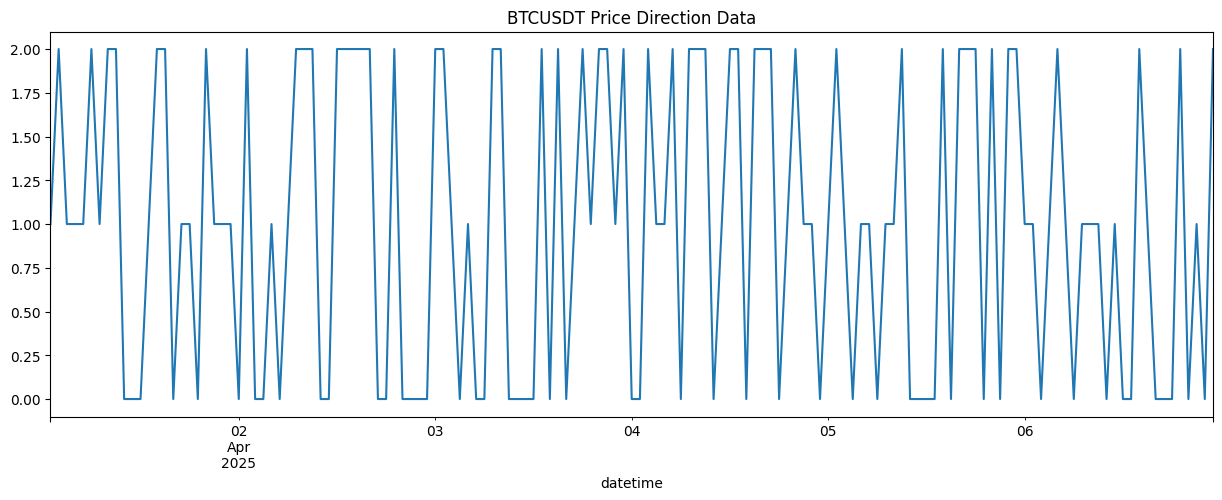

In [97]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
df_all['dir'].loc[(df_all.index > '2025-04-01') & (df_all.index < '2025-04-07')].plot(ax=ax,title='BTCUSDT Price Direction Data')

# Feature Engineering and Selection

In [99]:
import pandas as pd, numpy as np
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import mutual_info_classif

# ── CONFIG ─────────────────────────────────────────────────────────────
TARGET      = 'dir'
MAX_LAG     = 14
N_SPLITS    = 5
KEEP_PCT    = 0.30
HEAVY_PREF  = ('volume','ATR','OBV')

# 1) Prepare X_final, y (mutual-info lag selection) ─────────────────────
y  = df_all[TARGET]
X0 = df_all.drop(columns=[TARGET])

# build lags 1…MAX_LAG
frames = [X0.shift(L).add_suffix(f'_lag{L}') for L in range(1, MAX_LAG+1)]
X_lag = pd.concat(frames, axis=1).dropna()
y     = y.loc[X_lag.index]

# robust-scale heavy tails
heavy = [c for c in X_lag.columns if c.startswith(HEAVY_PREF)]
ct = ColumnTransformer([
    ('robust', RobustScaler(), heavy),
    ('keep',   'passthrough', [c for c in X_lag.columns if c not in heavy])
])

# avg MI over folds
mi = pd.Series(0.0, index=X_lag.columns)
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
for tr, _ in tscv.split(X_lag):
    Xtr = ct.fit_transform(X_lag.iloc[tr])
    ytr = y.iloc[tr]
    mi  += mutual_info_classif(Xtr, ytr, discrete_features=False)
mi /= N_SPLITS

# keep top KEEP_PCT of lags
k        = int(len(mi) * KEEP_PCT)
top_feats= mi.nlargest(k).index
X_red    = X_lag[top_feats]
X_red

,CEIL_real_lag13,MACDEXT_macdhist_lag3,MINUS_DM_real_lag2,MACDEXT_macd_lag4,ADXR_real_lag2,DX_real_lag6,LN_real_lag10,MACDFIX_macd_lag5,MOM_real_lag1,RSI_real_lag1,CCI_real_lag8,MACD_macdhist_lag5,MACD_macd_lag5,MINMAXINDEX_minidx_lag13,MACDEXT_macd_lag6,MINUS_DI_real_lag3,SUB_real_lag12,ADXR_real_lag8,SUM_real_lag12,MACDEXT_macdhist_lag5,AROON_aroondown_lag9,PLUS_DM_real_lag2,MACDFIX_macd_lag3,ATAN_real_lag5,ADX_real_lag9,ATAN_real_lag12,CCI_real_lag6,LN_real_lag12,MFI_real_lag4,MOM_real_lag3,MACD_macdhist_lag6,SIN_real_lag11,ROCR_real_lag1,MACD_macdsignal_lag5,FLOOR_real_lag12,MINMAX_max_lag13,MINMAXINDEX_maxidx_lag2,MINUS_DM_real_lag3,MACD_macd_lag6,CEIL_real_lag12,volume_lag1,MACDEXT_macd_lag5,DX_real_lag7,FLOOR_real_lag11,PPO_real_lag2,MACDFIX_macdhist_lag3,ADXR_real_lag10,MACDFIX_macdhist_lag4,SUM_real_lag13,ROCP_real_lag1,PLUS_DI_real_lag2,CMO_real_lag6,MFI_real_lag2,MACDFIX_macdsignal_lag2,SIN_real_lag10,SQRT_real_lag9,PLUS_DM_real_lag1,SIN_real_lag3,MACDFIX_macd_lag4,MININDEX_integer_lag14,BOP_real_lag7,MINMAX_max_lag14,MACD_macd_lag7,TAN_real_lag2,SIN_real_lag2,ATAN_real_lag13,MACDEXT_macdhist_lag4,MINMAX_min_lag14,SQRT_real_lag11,FLOOR_real_lag10,MINMAXINDEX_minidx_lag14,APO_real_lag9,ATAN_real_lag11,ADX_real_lag8,MOM_real_lag2,SUB_real_lag14,MACD_macdhist_lag4,COS_real_lag11,ADX_real_lag2,CEIL_real_lag11,MINUS_DI_real_lag1,TAN_real_lag10,BOP_real_lag6,SQRT_real_lag10,BOP_real_lag8,LOG10_real_lag10,SIN_real_lag9,MULT_real_lag14,TAN_real_lag9,AROON_aroonup_lag9,AROON_aroonup_lag7,MULT_real_lag13,MACDEXT_macdsignal_lag5,AROON_aroondown_lag8,AROON_aroonup_lag8,MINUS_DI_real_lag2,LN_real_lag11,DX_real_lag5,ADX_real_lag10,APO_real_lag8,MACD_macdsignal_lag6,HT_PHASOR_inphase_lag11,MIN_real_lag14,ADXR_real_lag9,MACDFIX_macdsignal_lag4,MINMAXINDEX_maxidx_lag13,AROONOSC_real_lag8,MINMAXINDEX_maxidx_lag14,MACDFIX_macdsignal_lag3,MIN_real_lag1,CDLLONGLINE_integer_lag4,AROONOSC_real_lag7,ROC_real_lag1,MINMAX_max_lag7,SMA_real_lag4,CDLSEPARATINGLINES_integer_lag5,COS_real_lag12,high_lag1,CCI_real_lag7,FLOOR_real_lag4,CDLTAKURI_integer_lag4,MACDFIX_macdhist_lag2,CORREL_real_lag1,CORREL_real_lag2,volume_lag12,CDLHIKKAKE_integer_lag7,LOG10_real_lag11,CORREL_real_lag3,CDLSTALLEDPATTERN_integer_lag3,PPO_real_lag3,MFI_real_lag3,TYPPRICE_real_lag2,SUB_real_lag13,T3_real_lag13,MULT_real_lag12,HT_PHASOR_quadrature_lag9,MACDEXT_macdsignal_lag4,AROON_aroondown_lag7,SQRT_real_lag3,PLUS_DI_real_lag1,CDLDOJI_integer_lag11,OBV_real_lag13,CDLHAMMER_integer_lag6,MACDEXT_macdsignal_lag3,CDL3WHITESOLDIERS_integer_lag12,MINUS_DM_real_lag1,PPO_real_lag1,ROCP_real_lag2,HT_SINE_sine_lag8,HT_SINE_leadsine_lag1,BETA_real_lag2,CDLLONGLINE_integer_lag6,TRIMA_real_lag13,FLOOR_real_lag3,LINEARREG_ANGLE_real_lag1,LOG10_real_lag3,MINMAX_max_lag9,SUB_real_lag2,CDLTAKURI_integer_lag3,CDLLONGLEGGEDDOJI_integer_lag7,SUB_real_lag6,WCLPRICE_real_lag1,HT_PHASOR_quadrature_lag7,CDLHANGINGMAN_integer_lag9,MACDFIX_macdhist_lag5,CMO_real_lag7,CDLSPINNINGTOP_integer_lag1,CDLHIGHWAVE_integer_lag8,TRANGE_real_lag14,CDLADVANCEBLOCK_integer_lag12,CDLBELTHOLD_integer_lag8,CDLGRAVESTONEDOJI_integer_lag10,LINEARREG_real_lag1,MOM_real_lag4,TYPPRICE_real_lag4,CDLSEPARATINGLINES_integer_lag4,MINMAXINDEX_minidx_lag9,CDLCLOSINGMARUBOZU_integer_lag11,SAREXT_real_lag11,MEDPRICE_real_lag3,low_lag11,SIN_real_lag1,CDLSHORTLINE_integer_lag4,HT_PHASOR_quadrature_lag1,ADXR_real_lag4,CDLIDENTICAL3CROWS_integer_lag7,MULT_real_lag1,CDLHIKKAKE_integer_lag8,CDLDRAGONFLYDOJI_integer_lag1,CDLSPINNINGTOP_integer_lag6,WMA_real_lag10,low_lag1,CDLENGULFING_integer_lag10,CDLSTALLEDPATTERN_integer_lag4,ATAN_real_lag1,MULT_real_lag6,high_lag13,LN_real_lag4,PLUS_DM_real_lag3,MIDPRICE_real_lag5,LINEARREG_INTERCEPT_real_lag1,open_lag11,CDLHARAMI_integer_lag9,DIV_real_lag9,PLUS_DI_real_lag4,CDLSEPARATINGLINES_integer_lag3,SAREXT_real_lag14,TYPPRICE_real_lag14,CDLDRAGONFLYDOJI_integer_lag9,T3_real_lag11,MACD_macd_lag1,CDLSTALLEDPATTERN_integer_lag1,CDLHAMMER_integer_lag1,DIV_real_lag11,SAR_real_lag11,MACDEXT_

In [100]:
# X is your DataFrame of selected features
corr = X_red.corr().abs()

# Build an “upper triangle” mask
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find columns to drop: any that have corr > thresh with an earlier col
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

X_reduced = X_red.drop(columns=to_drop)
X_reduced

,CEIL_real_lag13,MACDEXT_macdhist_lag3,MINUS_DM_real_lag2,MACDEXT_macd_lag4,ADXR_real_lag2,DX_real_lag6,MOM_real_lag1,RSI_real_lag1,CCI_real_lag8,MACD_macdhist_lag5,MINMAXINDEX_minidx_lag13,MINUS_DI_real_lag3,SUB_real_lag12,AROON_aroondown_lag9,PLUS_DM_real_lag2,CCI_real_lag6,MFI_real_lag4,MOM_real_lag3,SIN_real_lag11,ROCR_real_lag1,volume_lag1,DX_real_lag7,PPO_real_lag2,MACDFIX_macdhist_lag3,PLUS_DI_real_lag2,CMO_real_lag6,MFI_real_lag2,SIN_real_lag10,SIN_real_lag3,BOP_real_lag7,TAN_real_lag2,SIN_real_lag2,MOM_real_lag2,SUB_real_lag14,COS_real_lag11,MINUS_DI_real_lag1,TAN_real_lag10,BOP_real_lag6,BOP_real_lag8,SIN_real_lag9,TAN_real_lag9,AROON_aroonup_lag9,AROON_aroonup_lag7,AROON_aroondown_lag8,AROON_aroonup_lag8,DX_real_lag5,HT_PHASOR_inphase_lag11,AROONOSC_real_lag8,CDLLONGLINE_integer_lag4,AROONOSC_real_lag7,CDLSEPARATINGLINES_integer_lag5,COS_real_lag12,CCI_real_lag7,CDLTAKURI_integer_lag4,CORREL_real_lag1,volume_lag12,CDLHIKKAKE_integer_lag7,CDLSTALLEDPATTERN_integer_lag3,SUB_real_lag13,HT_PHASOR_quadrature_lag9,AROON_aroondown_lag7,CDLDOJI_integer_lag11,OBV_real_lag13,CDLHAMMER_integer_lag6,CDL3WHITESOLDIERS_integer_lag12,ROCP_real_lag2,HT_SINE_sine_lag8,HT_SINE_leadsine_lag1,BETA_real_lag2,CDLLONGLINE_integer_lag6,LINEARREG_ANGLE_real_lag1,SUB_real_lag2,CDLTAKURI_integer_lag3,CDLLONGLEGGEDDOJI_integer_lag7,SUB_real_lag6,HT_PHASOR_quadrature_lag7,CDLHANGINGMAN_integer_lag9,CDLSPINNINGTOP_integer_lag1,CDLHIGHWAVE_integer_lag8,CDLADVANCEBLOCK_integer_lag12,CDLBELTHOLD_integer_lag8,CDLGRAVESTONEDOJI_integer_lag10,MOM_real_lag4,CDLSEPARATINGLINES_integer_lag4,CDLCLOSINGMARUBOZU_integer_lag11,SAREXT_real_lag11,SIN_real_lag1,CDLSHORTLINE_integer_lag4,HT_PHASOR_quadrature_lag1,CDLIDENTICAL3CROWS_integer_lag7,CDLHIKKAKE_integer_lag8,CDLDRAGONFLYDOJI_integer_lag1,CDLSPINNINGTOP_integer_lag6,CDLENGULFING_integer_lag10,CDLSTALLEDPATTERN_integer_lag4,CDLHARAMI_integer_lag9,DIV_real_lag9,PLUS_DI_real_lag4,CDLSEPARATINGLINES_integer_lag3,SAREXT_real_lag14,CDLDRAGONFLYDOJI_integer_lag9,CDLSTALLEDPATTERN_integer_lag1,CDLHAMMER_integer_lag1,DIV_real_lag11,CDLSHORTLINE_integer_lag7,ROCP_real_lag4,RSI_real_lag4,HT_DCPERIOD_real_lag8,AROON_aroondown_lag1,NATR_real_lag1,CDLMATCHINGLOW_integer_lag6,CDLMARUBOZU_integer_lag4,MINUS_DI_real_lag6,NATR_real_lag10,COS_real_lag7,CDLSHORTLINE_integer_lag5,STOCH_slowk_lag1,BETA_real_lag1,COS_real_lag6,HT_PHASOR_inphase_lag1,MFI_real_lag7,CDLDOJI_integer_lag10,SUB_real_lag1,CDLHARAMI_integer_lag8,CDLHARAMICROSS_integer_lag6,MOM_real_lag6,CDLSPINNINGTOP_integer_lag3,CDLHARAMI_integer_lag6,DX_real_lag8,CDLRICKSHAWMAN_integer_lag5,CDLGRAVESTONEDOJI_integer_lag9,SAREXT_real_lag13,CDLCLOSINGMARUBOZU_integer_lag8,STDDEV_real_lag2,CDLRICKSHAWMAN_integer_lag3,CDLDRAGONFLYDOJI_integer_lag12,CDLSPINNINGTOP_integer_lag4,CDLHARAMICROSS_integer_lag7,CDLIDENTICAL3CROWS_integer_lag4,CDLMARUBOZU_integer_lag5,CDLTAKURI_integer_lag5,HT_SINE_leadsine_lag6,CCI_real_lag5,CDLMATCHINGLOW_integer_lag5,CDLHANGINGMAN_integer_lag6,CDLLONGLINE_integer_lag8,AROON_aroondown_lag11,HT_DCPERIOD_real_lag1,CCI_real_lag9,CDLENGULFING_integer_lag9,CDLHIKKAKE_integer_lag9,DX_real_lag1,CDLBELTHOLD_integer_lag13,HT_TRENDMODE_integer_lag1,CDLBELTHOLD_integer_lag11,SIN_real_lag5,CDLRICKSHAWMAN_integer_lag4,CDLHIKKAKEMOD_integer_lag7,CDLDRAGONFLYDOJI_integer_lag2,ADOSC_real_lag9,STDDEV_real_lag12,CDLMARUBOZU_integer_lag3,AROONOSC_real_lag11,DX_real_lag11,BOP_real_lag11,CCI_real_lag11,CDLMARUBOZU_integer_lag8,CDLHIKKAKEMOD_integer_lag6,CDLLONGLINE_integer_lag5,CDLBELTHOLD_integer_lag10,CDLLONGLEGGEDDOJI_integer_lag4,CDLDOJI_integer_lag9,CDLSHORTLINE_integer_lag2,ATR_real_lag1,CDLMARUBOZU_integer_lag6,CDLENGULFING_integer_lag8,CDLBELTHOLD_integer_lag2,DIV_real_lag1,HT_SINE_sine_lag6,BETA_real_lag4,AROON_aroonup_lag3,CDLSEPARATINGLINES_integer_lag2,CDLRICKSHAWMAN_integer_lag7,CDLIDENTICAL3CROWS_integer_lag9,CDLDRAGONFLYDOJI_integer_lag7,ret1_lag11,AROON_aroonup_lag6,LINEARREG_ANGLE_real_lag3,CDLLONGLEGGEDDOJI_integer_lag5,HT_PHASOR_inphase_lag7,C

## Feature Selection Method 1: Boruta

In [101]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# --- 1) Set up a RandomForest with enough trees ----------------------------
rf = RandomForestClassifier(
    n_estimators=500,        # BorutaPy will actually override this with 'auto'
    max_depth=None,
    class_weight='balanced', # good for imbalanced classes
    n_jobs=-1,
    random_state=42
)

# --- 2) Wrap in BorutaPy ---------------------------------------------------
boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',     # let Boruta pick a sufficient forest size
    verbose=2,               # shows you progress of the shadow‐feature tests
    random_state=42,
)

# --- 3) Fit on your training data ------------------------------------------
# Pass the raw values; BorutaPy does its own internal shadow‐feature testing
boruta.fit(X_reduced.values, y.values)

# --- 4) Extract and rank all features by Boruta rank ------------------------
# boruta.ranking_: array of ints, 1 = confirmed important, ↑ = less important
ranks = pd.Series(boruta.ranking_, index=X_reduced.columns)

# Sort ascending (1 = best), then take the top 15 names
boruta_selected_mc = ranks.sort_values().head(30).index.tolist()
X_boruta = X_reduced[boruta_selected_mc].copy() 

print("Top 15 features by Boruta rank:")
for i, feat in enumerate(boruta_selected_mc, 1):
    print(f"{i:2d}. {feat} (rank={ranks[feat]})")


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	26
Tentative: 	9
Rejected: 	246
Iteration: 	9 / 100
Confirmed: 	26
Tentative: 	9
Rejected: 	246
Iteration: 	10 / 100
Confirmed: 	26
Tentative: 	9
Rejected: 	246
Iteration: 	11 / 100
Confirmed: 	26
Tentative: 	9
Rejected: 	246
Iteration: 	12 / 100
Confirmed: 	26
Tentative: 	9
Rejected: 	246
Iteration: 	13 / 100
Confirmed: 	26
Tentative: 	7
Rejected: 	248
Iteration: 	14 / 100
Confirmed: 	26
Tentative: 	7
Rejected: 	248
Iteration: 	15 / 100
Confirmed: 	26
Tentative: 	7
Rejected: 	248
Iteration: 	16 / 100
Confirmed: 	26
Tenta

## Feature Selection Method 2: Genetic Algorithm

In [119]:
# ## In[3]: Genetic Algorithm (wrapper) for multiclass
# from genetic_selection import GeneticSelectionCV

# estimator_mc = RandomForestClassifier(n_jobs=-1, random_state=42)
# selector_mc = GeneticSelectionCV(
#     estimator=estimator_mc,
#     cv=5,
#     scoring='accuracy',
#     n_population=50,
#     crossover_proba=0.5,
#     mutation_proba=0.2,
#     n_generations=40,
#     n_jobs=-1,
#     max_features=50,
#     verbose=1
# )
# selector_mc.fit(X_red.values, y.values)
# ga_selected_mc = list(X_red.columns[selector_mc.support_])
# print("GA selected (multiclass):", ga_selected_mc)
# X_ga = X_red[ga_selected_mc].copy()

## Feature Selection Method 3: LightGMB

In [120]:
# ## In[4]: LightGBM embedded for multiclass
# import lightgbm as lgb

# lgbm_mc = lgb.LGBMClassifier(
#     objective='multiclass',
#     num_class=3,
#     random_state=42
# )
# lgbm_mc.fit(X_red, y)
# importances_mc = pd.Series(
#     lgbm_mc.feature_importances_, index=X_red.columns
# )
# lgbm_selected_mc = list(importances_mc.nlargest(15).index)
# print("LightGBM top 15 (multiclass):", lgbm_selected_mc)

# # 2) Use only selected features for tuning
# X_lgbm = X_red[lgbm_selected_mc].copy()

# Machine Learning 

In [116]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import pandas as pd

# 1) Prepare X and y
X = X_boruta.copy()   
y = y.copy()

X_train = X.loc[(X.index < '2024-06-01')]
y_train = y.loc[(X.index < '2024-06-01')]

X_val = X.loc[(X.index >= '2024-01-01')]
y_val = y.loc[(X.index >= '2024-01-01')]

clf = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    # use_label_encoder=False,
    random_state=42,
    n_jobs=-1,

    # Complexity control
    n_estimators=10000,          # start big, prune with ES
    early_stopping_rounds=50,   # stop if no val-loss improvement for 50 rounds
    max_depth=30,                # shallow trees generalize better
    learning_rate=0.005,         # smaller step size → smoother fit
    subsample=0.8,              # row sampling
    colsample_bytree=0.8,       # feature sampling

    # Split regularization
    gamma=1.0,                  # min loss reduction to make a split
    min_child_weight=5,         # min sum hessian in a leaf

    # Weight regularization
    reg_alpha=1.,              # L1
    reg_lambda=1.5,             # L2

    # Handle class imbalance
    # scale_pos_weight=ratio_dict, # e.g. {0:1,1:?,2:?} or a single float

)
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100,
)

[0]	validation_0-mlogloss:1.09691	validation_1-mlogloss:1.09797
[100]	validation_0-mlogloss:0.95168	validation_1-mlogloss:1.04494
[200]	validation_0-mlogloss:0.84303	validation_1-mlogloss:1.00607
[300]	validation_0-mlogloss:0.75893	validation_1-mlogloss:0.97688
[400]	validation_0-mlogloss:0.69278	validation_1-mlogloss:0.95431
[500]	validation_0-mlogloss:0.64002	validation_1-mlogloss:0.93695
[600]	validation_0-mlogloss:0.59950	validation_1-mlogloss:0.92406
[700]	validation_0-mlogloss:0.56968	validation_1-mlogloss:0.91463
[800]	validation_0-mlogloss:0.54962	validation_1-mlogloss:0.90865
[900]	validation_0-mlogloss:0.53781	validation_1-mlogloss:0.90503
[1000]	validation_0-mlogloss:0.53044	validation_1-mlogloss:0.90279
[1100]	validation_0-mlogloss:0.52518	validation_1-mlogloss:0.90125
[1200]	validation_0-mlogloss:0.52135	validation_1-mlogloss:0.90012
[1300]	validation_0-mlogloss:0.51888	validation_1-mlogloss:0.89949
[1400]	validation_0-mlogloss:0.51694	validation_1-mlogloss:0.89893
[1500]	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=1.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None,
              n_estimators=10000, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softprob', ...)

<Axes: >

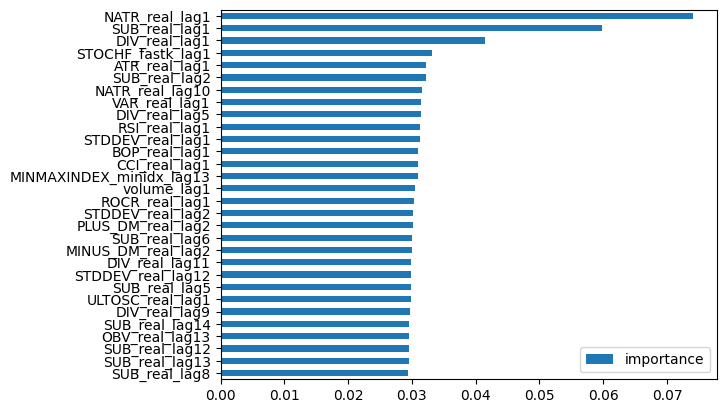

In [117]:
fi = pd.DataFrame(data = clf.feature_importances_,
                  index = clf.feature_names_in_,
                  columns = ['importance'])
fi.sort_values('importance').plot(kind='barh')

In [118]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Predict labels on the validation set
y_pred = clf.predict(X_val)

# 2) Compute accuracy
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy:.4f}")

# 3) (Optional) More diagnostics
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Validation accuracy: 0.6014

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.46      0.54      3704
           1       0.61      0.66      0.63      3797
           2       0.56      0.68      0.61      3940

    accuracy                           0.60     11441
   macro avg       0.61      0.60      0.60     11441
weighted avg       0.61      0.60      0.60     11441


Confusion Matrix:
[[1706  789 1209]
 [ 406 2494  897]
 [ 476  783 2681]]
